### To view this notebook with interactive plots, follow [THIS LINK](http://nbviewer.jupyter.org/github/mferrari3/pyladies-stats/blob/master/pyladies_chapters.ipynb)

# Getting PyLadies chapter information.
PyLadies has many chapters listed on its webpage `https://www.pyladies.com/locations`. I would like to do some analytics to understand how each chapter interacts with its members.

## Download requirements.
I will use the API provided by Meetup, which I install via the following:
``` shell
pip install meetup-api
```

## Import relevant packages.

In [1]:
import requests
import random
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import meetup.api
import plotly.plotly as py
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
font = {'family' : 'sans-serif',
        'size'   : 16}

matplotlib.rc('font', **font)

## Scrape the PyLadies website for chapters and social media links.

In [3]:
pyladies_request = requests.get('https://www.pyladies.com/locations')
pyladies_soup = BeautifulSoup(pyladies_request.text, 'html.parser')

In [4]:
all_chapters = pyladies_soup.find_all(class_="chapter_location")
print('There are {} PyLadies chapters listed on the PyLadies website'.format(len(all_chapters)))

There are 84 PyLadies chapters listed on the PyLadies website


#### Determine social media links.

For a given chapter, we can access the information on the website by looking at the html code:

In [5]:
ix = 5
single_chapter = all_chapters[ix]
single_chapter

<div class="chapter_location" data-chapter-name="Australia" data-meetup-id="">
<div class="logo-container">
<img alt="Australia" src="../assets/images/pyladies_australia.png"/>
</div>
<h3 class="chpts chapter-name">
<a href="/locations/http://australia.pyladies.com/">
                            
                            Australia</a>
</h3>
<h3 class="chpts social-icons">
<a class="social icon link" data-icon="🔗" href="http://australia.pyladies.com/" title="Website"></a>
<a class="social icon vcard" data-icon="" href="/cdn-cgi/l/email-protection#82e3f7f1f6f0e3eeebe3c2f2fbeee3e6ebe7f1ace1edef" title="Contact"></a>
<a class="social icon facebook" data-icon="" href="https://www.facebook.com/pyladiesau" title"facebook"=""></a>
<a class="social icon github" data-icon="" href="https://github.com/PyLadiesAU" title"github"=""></a>
<a class="social icon twitter" data-icon="" href="https://twitter.com/pyladiesau" title="Twitter"></a>
</h3>
</div>

Lets look at the social media links for a given chapter:

In [6]:
social_links = single_chapter.find_all('a', attrs={"class":"social"})
social_links

[<a class="social icon link" data-icon="🔗" href="http://australia.pyladies.com/" title="Website"></a>,
 <a class="social icon vcard" data-icon="" href="/cdn-cgi/l/email-protection#82e3f7f1f6f0e3eeebe3c2f2fbeee3e6ebe7f1ace1edef" title="Contact"></a>,
 <a class="social icon facebook" data-icon="" href="https://www.facebook.com/pyladiesau" title"facebook"=""></a>,
 <a class="social icon github" data-icon="" href="https://github.com/PyLadiesAU" title"github"=""></a>,
 <a class="social icon twitter" data-icon="" href="https://twitter.com/pyladiesau" title="Twitter"></a>]

In [7]:
social_platforms = set([])
bad_links = []
for single_chapter in all_chapters:
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    for social_link in social_links:
        if social_link.has_attr("title"):
            social_platforms.add(social_link['title'])
        else:
            bad_links.append(social_link)
print(f'The social platforms found: {social_platforms}\n')
print(f'There were {len(bad_links)} links without a title attribute. A sample bad link is: \n{random.choice(bad_links)}')

The social platforms found: {'Meetup Link', 'Twitter', 'Contact', 'Website', 'Timepad Link'}

There were 52 links without a title attribute. A sample bad link is: 
<a class="social icon github" data-icon="" href="https://github.com/PyLadiesAU" title"github"=""></a>


Here is where I noticed that the `title` attribute for social media links corresponding to Facebook, Google+, and Github had syntax errors. I created a Pull Request for the PyLadies website to fix this:

```html 
<!-- BEFORE -->
<a class="social icon github" title"github"=""></a>

<!-- AFTER -->
<a class="social icon github" title="github"></a>
```

While the HTML code is getting fixed, we can access the social link by the `class` attribute.

In [8]:
social_link.attrs

{'class': ['social', 'icon', 'vcard'],
 'data-icon': '\ue722',
 'href': '/cdn-cgi/l/email-protection#7b011a09121a3b0b02171a1f121e0855181416',
 'title': 'Contact'}

In [9]:
social_link['class'][-1]

'vcard'

In [10]:
social_platforms = set([])
for single_chapter in all_chapters:
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    for social_link in social_links:
        social_platforms.add(social_link['class'][-1])
print(f'The social platforms found: {social_platforms}')

The social platforms found: {'google-plus', 'github', 'link', 'location', 'twitter', 'vcard', 'facebook'}


Note that for class description: 
- `link = website link` 
- `location = Meetup Link`, expect when `location = Timepad Link` for PyLadies St. Petersburg.

In [11]:
social_platforms = set([])
bad_links = []
for single_chapter in all_chapters:
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    for social_link in social_links:
        if social_link.has_attr("title"):
            social_platforms.add(social_link['title'])
        else:
            social_platforms.add(social_link['class'][-1])
print(f'The social platforms found: \n{social_platforms}')

The social platforms found: 
{'Meetup Link', 'google-plus', 'github', 'Twitter', 'Contact', 'facebook', 'Website', 'Timepad Link'}


In [12]:
chapter_info = pd.DataFrame(columns=social_platforms)

for chapter_id, single_chapter in enumerate(all_chapters):
    chapter_dict = {}
    social_links = single_chapter.find_all('a', attrs={"class":"social"})
    chapter_dict['chapter_id'] = chapter_id
    chapter_name = single_chapter.find("h3", class_="chpts chapter-name").find("a").text.strip()
    chapter_dict['chapter_name'] = chapter_name
    for social_link in social_links:
        if social_link.has_attr("title"):
            chapter_dict[social_link['title']] = social_link['href']
        else:
            chapter_dict[social_link['class'][-1]] = social_link['href']
    chapter_info = chapter_info.append(chapter_dict, ignore_index=True)
    
chapter_info['chapter_id'] = chapter_info['chapter_id'].astype('int')
chapter_info = chapter_info.set_index(['chapter_id', 'chapter_name'])
chapter_info.head()

,,Meetup Link,google-plus,github,Twitter,Contact,facebook,Website,Timepad Link
chapter_id,chapter_name,,,,,,,,
0,"Amsterdam, the Netherlands",http://www.meetup.com/PyLadiesAMS/,NaN,NaN,https://twitter.com/PyLadiesAMS,/cdn-cgi/l/email-protection#32535f414657405653...,NaN,amsterdam,NaN
1,"Antananarivo, MDG",NaN,NaN,NaN,https://twitter.com/PyladiesMDG,/cdn-cgi/l/email-protection#2753495567575e4b46...,NaN,tnr,NaN
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/,NaN,NaN,https://twitter.com/PyladiesAracati,/cdn-cgi/l/email-protection#147566757775607d54...,NaN,NaN,NaN
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/,NaN,NaN,https://twitter.com/pyladiesATL,/cdn-cgi/l/email-protection#4c2d38200c3c35202d...,NaN,atl,NaN
4,"Austin, TX",http://www.meetup.com/pyladies-atx/,NaN,NaN,https://twitter.com/pyladiesATX,/cdn-cgi/l/email-protection#f293868ab2828b9e93...,NaN,atx,NaN


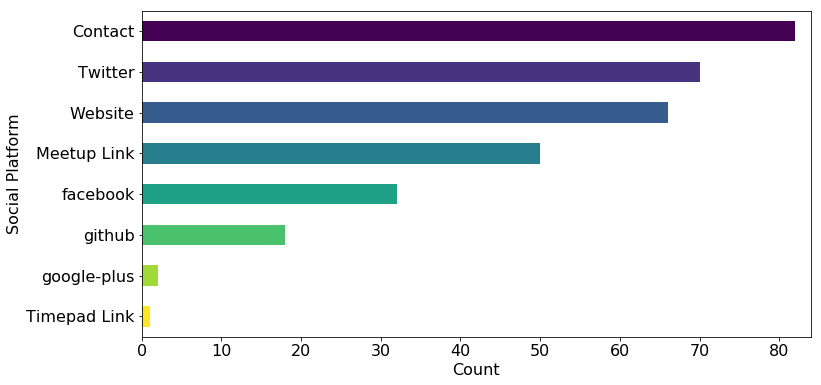

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
color = matplotlib.cm.viridis_r(np.linspace(0, 1, len(chapter_info.columns)))
chapter_info.count().sort_values().plot(kind='barh', ax=ax, color=color);
ax.set_xlim(xmax=chapter_info.index.get_level_values(level='chapter_id').max()+1);
ax.set_ylabel('Social Platform') ; ax.set_xlabel('Count');

In [14]:
chapter_info.to_csv('chapter_info.gz', compression='gzip')

#### Open Question:
1. Determine which social platform is used across state, country, continent

## Meetup.
I will be working with the Meetup API. To get your own API key, just go to the [Meetup API Website](https://www.meetup.com/meetup_api/)

In [364]:
client = meetup.api.Client()
client.api_key = '571f757f1421323f344b1f1b67676b66'#'insert-your-key-here'

In [16]:
chapter_meetups = chapter_info[['Meetup Link']]
chapter_meetups.head()

,,Meetup Link
chapter_id,chapter_name,
0,"Amsterdam, the Netherlands",http://www.meetup.com/PyLadiesAMS/
1,"Antananarivo, MDG",NaN
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/
4,"Austin, TX",http://www.meetup.com/pyladies-atx/


In [17]:
meetup_api_cols = ['meetup_name', 'group_id', 'status', 'meetup_members', 'date_created',
                   'country', 'state', 'city', 'timezone', 'longitude', 'latitude', 
                   'num_future', 'num_past', 'num_past_scraped', 'next_meetup', 'last_meetup', 'last_meetup_rsvp']

In [22]:
chapter_meetups = pd.concat([chapter_meetups, pd.DataFrame(columns=meetup_api_cols)], sort=False)

In [23]:
chapter_meetups.columns

Index(['Meetup Link', 'meetup_name', 'group_id', 'status', 'meetup_members',
       'country', 'state', 'city', 'timezone', 'longitude', 'latitude',
       'num_future', 'num_past', 'num_past_scraped', 'next_meetup',
       'last_meetup', 'last_meetup_rsvp'],
      dtype='object')

In [24]:
chapter_meetups.head()

,,Meetup Link,meetup_name,group_id,status,meetup_members,country,state,city,timezone,longitude,latitude,num_future,num_past,num_past_scraped,next_meetup,last_meetup,last_meetup_rsvp
chapter_id,chapter_name,,,,,,,,,,,,,,,,,
0,"Amsterdam, the Netherlands",http://www.meetup.com/PyLadiesAMS/,PyLadies Amsterdam,9301202,active,301,NL,,Amsterdam,Europe/Amsterdam,4.89,52.37,0,13,13,NaN,2015-12-10 12:00:00,18
1,"Antananarivo, MDG",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Austin, TX",http://www.meetup.com/pyladies-atx/,PyLadies ATX,5947662,active,1023,US,TX,Austin,US/Central,-97.76,30.24,12,185,187,2018-11-19 20:00:00,2018-10-30 19:30:00,19


In [25]:
for ix, row in chapter_meetups.iterrows():
    
    meetup_url = row['Meetup Link']
    if not pd.isnull(meetup_url):
        row_request = requests.get(meetup_url)
        if row_request.status_code != 200:
            pass
        else:
            
            print(meetup_url)
            
            ## Get the Meetup Group details.
            group_info = client.GetGroup({'urlname': meetup_url.split('meetup.com/')[1]})

            date_created = datetime.fromtimestamp(group_info.created/1000.0)

            ## Get all future and past events.
            future_activity = client.GetEvents(group_id = group_info.id)
            past_activity = client.GetEvents(group_id = group_info.id, status='past')

            num_future = future_activity.meta['total_count']            
            num_past = past_activity.meta['total_count']

            ## I found that the number of past events wasn't always accurate with the API, so I also find it using web scraping.
            row_soup = BeautifulSoup(row_request.text, 'html.parser')
            events = row_soup.find_all(class_="text--sectionTitle text--bold padding--bottom")
            num_past_scraped = int([f for f in events if "Past" in str(f)][0].text.split('(')[1].split(')')[0])
            
            if num_future > 0:
                next_date = datetime.fromtimestamp(future_activity.results[0]['time']/1000.0)  
            else:
                next_date = np.nan
                
            if num_past == 0 and num_past_scraped != 0: 
                last_date = datetime.fromtimestamp(int(row_soup.find_all("time", class_="")[0]['datetime'])/1000.0) 
                yes_rsvp = int(row_soup.find_all("li", class_="avatarRow--attendingCount display--inline text--small text--secondary")[0].text.split(' ')[0])
            elif num_past > 0:
                last_date = datetime.fromtimestamp(past_activity.results[-1]['time']/1000.0)
                yes_rsvp = past_activity.results[-1]['yes_rsvp_count']
            else: 
                last_date = np.nan
                yes_rsvp = np.nan 
                
            chapter_meetups.loc[ix, meetup_api_cols] = [group_info.name, group_info.id, group_info.status, group_info.members, date_created,
                                                        group_info.country, group_info.state, group_info.city, group_info.timezone, 
                                                        group_info.lon, group_info.lat,
                                                        num_future, num_past, num_past_scraped, next_date, last_date, yes_rsvp]

http://www.meetup.com/PyLadiesAMS/
29/30 (10 seconds remaining)
28/30 (10 seconds remaining)
27/30 (10 seconds remaining)
http://www.meetup.com/pyladies-atx/
26/30 (7 seconds remaining)
25/30 (7 seconds remaining)
24/30 (7 seconds remaining)
http://www.meetup.com/PyLadies-BH-Meetup/
23/30 (3 seconds remaining)
22/30 (3 seconds remaining)
21/30 (3 seconds remaining)
http://www.meetup.com/PyLadies-Berlin/
20/30 (2 seconds remaining)
19/30 (2 seconds remaining)
18/30 (2 seconds remaining)
http://www.meetup.com/PyLadies-Boston/
17/30 (0 seconds remaining)
16/30 (0 seconds remaining)
15/30 (0 seconds remaining)
http://www.meetup.com/pyladiescz/
29/30 (10 seconds remaining)
28/30 (10 seconds remaining)
27/30 (10 seconds remaining)
http://www.meetup.com/PyLadiesCaxiasdoSul/
26/30 (9 seconds remaining)
25/30 (9 seconds remaining)
24/30 (9 seconds remaining)
http://www.meetup.com/Chicago-PyLadies/
23/30 (6 seconds remaining)
22/30 (6 seconds remaining)
21/30 (6 seconds remaining)
http://www.mee

In [368]:
#chapter_meetups.to_csv('chapter_meetups.gz', compression='gzip')
chapter_meetups = pd.read_csv('chapter_meetups.gz', compression='gzip')chapter_meetups

In [369]:
chapter_meetups.dropna(subset=['Meetup Link'])

,chapter_id,chapter_name,Meetup Link,meetup_name,group_id,status,meetup_members,country,state,city,timezone,longitude,latitude,num_future,num_past,num_past_scraped,next_meetup,last_meetup,last_meetup_rsvp,date_created
0,0,"Amsterdam, the Netherlands",http://www.meetup.com/PyLadiesAMS/,PyLadies Amsterdam,9301202.0,active,298.0,NL,NaN,Amsterdam,Europe/Amsterdam,4.89,52.37,0.0,13.0,13.0,NaN,2015-12-10 12:00:00,18.0,2013-07-10 15:49:40
2,2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,4,"Austin, TX",http://www.meetup.com/pyladies-atx/,PyLadies ATX,5947662.0,active,1023.0,US,TX,Austin,US/Central,-97.76,30.24,12.0,185.0,187.0,2018-11-19 20:00:00,2018-10-30 19:30:00,19.0,2012-11-21 16:52:24
6,6,"Bangalore, India",http://www.meetup.com/PyladiesBangalore/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
9,9,"Belo Horizonte, Brazil",http://www.meetup.com/PyLadies-BH-Meetup/,PyLadies BH Meetup,18890724.0,active,190.0,BR,NaN,Belo Horizonte,America/Sao_Paulo,-43.94,-19.92,0.0,2.0,2.0,NaN,2016-05-21 13:00:00,11.0,2015-09-01 20:52:48
10,10,"Berlin, Germany",http://www.meetup.com/PyLadies-Berlin/,PyLadies Berlin,8623152.0,active,1146.0,DE,NaN,Berlin,Europe/Berlin,13.38,52.52,2.0,65.0,66.0,2018-11-13 13:00:00,2018-10-27 04:00:00,4.0,2013-05-24 07:27:07
13,13,"Boston, MA",http://www.meetup.com/PyLadies-Boston/,PyLadies Boston,8401402.0,active,1253.0,US,MA,Boston,US/Eastern,-71.06,42.36,0.0,0.0,199.0,NaN,2018-09-27 18:00:00,17.0,2013-05-08 12:07:37
16,16,"Brno, Czech Republic",http://www.meetup.com/pyladiescz/,PyWorking Sessions - Praha,5160912.0,active,301.0,CZ,NaN,Prague,Europe/Prague,14.43,50.08,3.0,45.0,46.0,2018-11-19 12:00:00,2018-11-05 12:00:00,13.0,2012-09-29 09:17:01
19,19,"Caxias do Sul, Brazil",http://www.meetup.com/PyLadiesCaxiasdoSul/,PyLadies Caxias do Sul,26586870.0,grace,75.0,BR,NaN,Caxias do Sul,America/Sao_Paulo,-51.17,-29.18,1.0,5.0,5.0,2018-11-10 05:00:00,2018-09-22 07:30:00,4.0,2017-11-13 12:21:35


### Inactive Meetups.
The following meetup links are listed on the PyLadies website, but have do not have an active status on Meetup.

In [27]:
innactive_meetups = chapter_meetups.dropna(subset=['Meetup Link'])[chapter_meetups.dropna(subset=['Meetup Link'])['status'].isnull()][['Meetup Link']]
innactive_meetups

,,Meetup Link
chapter_id,chapter_name,
2,"Aracati, Brazil",http://www.meetup.com/PyladeisAracati/
3,"Atlanta, GA",http://www.meetup.com/pyladiesATL/
6,"Bangalore, India",http://www.meetup.com/PyladiesBangalore/
20,"Charleston, SC",http://www.meetup.com/PyLadies-Charleston/
23,"Dallas, TX",http://www.meetup.com/dfw-pyladies/
32,"Ho Chi Minh, Vietnam",http://www.meetup.com/hcmc-pyladies/
35,"Kampala, Uganda",http://www.meetup.com/pyladies-kampala/
41,"Maceio, Brazil",http://www.meetup.com/Maceio PyLadies/
42,"Milan, Italy",http://www.meetup.com/PyLadies-Milano/


In [28]:
print('The following Meetup pages are innactive:\n')
print('\n'.join('{}'.format(item) for item in list(innactive_meetups.index.get_level_values('chapter_name'))))

The following Meetup pages are innactive:

Aracati, Brazil
Atlanta, GA
Bangalore, India
Charleston, SC
Dallas, TX
Ho Chi Minh, Vietnam
Kampala, Uganda
Maceio, Brazil
Milan, Italy
Nashville, TN
Nigeria
Ojere, NG
Salvador, Brazil
Singapore


#### Open Questions:
1. Are innactive Meetup groups using another form of social media to advertise their events?

### Meetup Statistics.

In [29]:
print('There are {} PyLadies members on Meetup in {} different countries'.format(chapter_meetups['meetup_members'].sum(), chapter_meetups.country.nunique()))

There are 30023 PyLadies members on Meetup in 15 different countries


In [30]:
print('There have been {} PyLadies events through Meetup'.format(chapter_meetups['num_past_scraped'].sum()))

There have been 2792 PyLadies events through Meetup


In [31]:
## Meetups sorted by number of members
chapter_meetups.sort_values('meetup_members', ascending=False).head(n=20)

,,Meetup Link,meetup_name,group_id,status,meetup_members,country,state,city,timezone,longitude,latitude,num_future,num_past,num_past_scraped,next_meetup,last_meetup,last_meetup_rsvp
chapter_id,chapter_name,,,,,,,,,,,,,,,,,
64,"San Francisco, CA",http://www.meetup.com/pyladiessf/,PyLadies of San Francisco,3604052,active,5152,US,CA,San Francisco,US/Pacific,-122.4,37.77,10,393,401,2018-11-15 21:00:00,2016-04-16 16:00:00,22
49,"New York, NY",http://www.meetup.com/nyc-pyladies/,NYC PyLadies,4576312,active,3262,US,NY,New York,US/Eastern,-73.99,40.75,2,124,127,2018-11-14 18:30:00,2018-10-30 18:30:00,76
66,"Seattle, WA",http://www.meetup.com/seattle-pyladies/,Seattle PyLadies,5411282,active,1714,US,WA,Seattle,US/Pacific,-122.29,47.68,65,245,245,2018-11-14 21:00:00,2017-11-13 20:15:00,15
38,"London, UK",http://www.meetup.com/pyladieslondon/,PyLadies London,13320732,active,1596,GB,17,London,Europe/London,-0.13,51.51,0,57,57,NaN,2018-10-03 13:00:00,21
73,Taiwan,http://www.meetup.com/PyLadiesTW/,PyLadies Taiwan,13106102,active,1496,TW,,Taipei,Asia/Taipei,121.45,25.02,1,76,76,2018-11-18 01:00:00,2018-09-29 02:00:00,31
13,"Boston, MA",http://www.meetup.com/PyLadies-Boston/,PyLadies Boston,8401402,active,1250,US,MA,Boston,US/Eastern,-71.06,42.36,0,0,199,NaN,2018-09-27 18:00:00,17
56,"Pune, India",http://www.meetup.com/PyLadies-Pune/,PyLadies Pune,17516492,active,1202,IN,,Pune,Asia/Calcutta,73.84,18.53,0,17,17,NaN,2017-11-19 00:30:00,17
10,"Berlin, Germany",http://www.meetup.com/PyLadies-Berlin/,PyLadies Berlin,8623152,active,1149,DE,,Berlin,Europe/Berlin,13.38,52.52,1,66,67,2018-11-20 13:00:00,2018-11-13 13:00:00,50
82,"Washington, DC",http://www.meetup.com/dc-pyladies/,DC PyLadies,2292131,active,1142,US,DC,Washington,US/Eastern,-77.02,38.95,0,80,80,NaN,2018-08-04 13:00:00,25


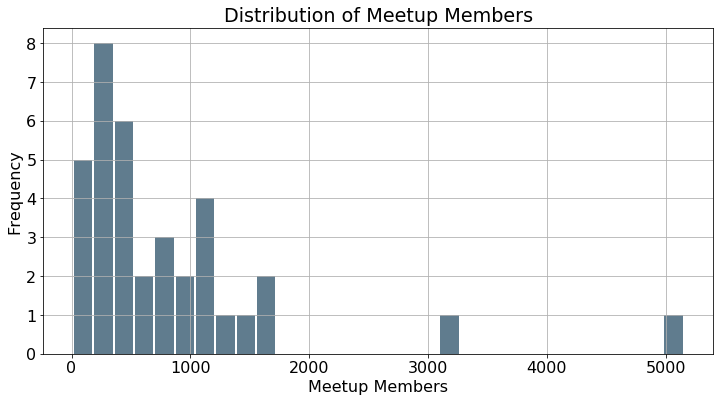

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
chapter_meetups.dropna(subset=["status"])['meetup_members'].astype('int').hist(grid=True, bins=30, rwidth=0.9, color='#607c8e', ax=ax);
ax.set_xlabel('Meetup Members'); ax.set_ylabel('Frequency');
ax.set_title('Distribution of Meetup Members');

In [371]:
US_groups = chapter_meetups[chapter_meetups.country == 'US'].copy()

In [382]:
US_groups['text'] = US_groups['meetup_name'] +\
                    '<br>Created: ' + (US_groups['date_created']).astype(str) +\
                    '<br>Members: ' + (US_groups['meetup_members'].astype(int)).astype(str) +\
                    '<br>Past Meetups: ' + (US_groups['num_past_scraped'].astype(int)).astype(str) 
scale = US_groups.meetup_members.max()

chapters = dict(
    type = 'scattergeo',
    locationmode = 'USA-states',
    lon = US_groups['longitude'],
    lat = US_groups['latitude'],
    text = US_groups['text'],
    marker = dict(
        size = US_groups['meetup_members']/scale,
        sizeref = 2. * max(US_groups['meetup_members']/scale) / (50 ** 2),
        color = US_groups['meetup_members'],
        colorscale='Viridis',
        colorbar=dict(title='Number of Members'),
        line = dict(color='rgb(40,40,40)', width=2),
        sizemode = 'area'),  #'area', 'diameter'
    )

layout = dict(
        title = 'PyLadies Meetup Members<br>(USA Locations)',
        geo = dict(
            scope='usa', #"world" | "usa" | "europe" | "asia" | "africa" | "north america" | "south america"
            projection=dict( type='albers usa' ), #type = 'Mercator'type='albers usa'
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=[chapters], layout=layout)
py.iplot(fig, validate=False, filename='d3-bubble-map-meetup_members_US')

In [385]:
chapter_meetups['text'] = chapter_meetups['meetup_name'] +\
                            '<br>Created: ' + (chapter_meetups['date_created']).astype(str) +\
                            '<br>Members ' + (chapter_meetups['meetup_members']).astype(str) +\
                            '<br>Past Meetups ' + (chapter_meetups['num_past_scraped']).astype(str)
scale = chapter_meetups.meetup_members.max()

chapters = dict(
    type = 'scattergeo',
    lon = chapter_meetups['longitude'],
    lat = chapter_meetups['latitude'],
    text = chapter_meetups['text'],
    marker = dict(
        size = chapter_meetups['meetup_members']/scale,
        sizeref = 2. * max(chapter_meetups['meetup_members']/scale) / (50 ** 2),
        color = chapter_meetups['meetup_members'],
        colorscale='Viridis',
        colorbar=dict(title='Number of Members'),
        line = dict(color='rgb(40,40,40)', width=2),
        sizemode = 'area'),  #'area', 'diameter'
    )

layout = dict(
        title = 'PyLadies Meetup Members<br>Worldwide',
        geo = dict(
            scope='world', #"world" | "usa" | "europe" | "asia" | "africa" | "north america" | "south america"
            projection=dict( type='Mercator' ), #type = 'Mercator'type='albers usa'
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=[chapters], layout=layout)
py.iplot(fig, validate=False, filename='d3-bubble-map-meetup_members_worldwide')

# Meetup events.

In [331]:
chapter_meetups = pd.read_csv('chapter_meetups.gz', compression='gzip')

In [179]:
active_meetups = chapter_meetups.dropna(subset=['Meetup Link', 'status'])[['Meetup Link', 'group_id', 'country', 'state', 'city']]
active_meetups.head()

,Meetup Link,group_id,country,state,city
0,http://www.meetup.com/PyLadiesAMS/,9301202.0,NL,NaN,Amsterdam
4,http://www.meetup.com/pyladies-atx/,5947662.0,US,TX,Austin
9,http://www.meetup.com/PyLadies-BH-Meetup/,18890724.0,BR,NaN,Belo Horizonte
10,http://www.meetup.com/PyLadies-Berlin/,8623152.0,DE,NaN,Berlin
13,http://www.meetup.com/PyLadies-Boston/,8401402.0,US,MA,Boston


In [180]:
meetup_event_cols = ['urlname', 'venue', 'rsvp_limit', 'waitlist_count', 'description', 'event_url', 
                     'yes_rsvp_count', 'duration', 'announced', 'name', 'id', 'time']

In [208]:
df_events = pd.DataFrame(columns=meetup_event_cols + list(active_meetups.columns))
df_events

,urlname,venue,rsvp_limit,waitlist_count,description,event_url,yes_rsvp_count,duration,announced,name,id,time,Meetup Link,group_id,country,state,city


In [209]:
for ix, row in active_meetups.iterrows():
    
    meetup_url = row['Meetup Link']
    if not pd.isnull(meetup_url):
        print(meetup_url)

        ## Get the Meetup Group details.
        group_info = client.GetGroup({'urlname': meetup_url.split('meetup.com/')[1]})

        ## Get all future and past events.
        future_activity = client.GetEvents(group_id = group_info.id)
        past_activity = client.GetEvents(group_id = group_info.id, status='past')

        for activity in past_activity.results:
            urlname = activity['group']['urlname']
            data = [urlname]
            for col in meetup_event_cols[1:]:
                data.append(activity.get(col))
            data.extend(row.values)
            
            df_events = df_events.append(pd.DataFrame(columns=meetup_event_cols + list(active_meetups.columns), 
                                                      data=[data]), ignore_index=True)

df_events['time'] = df_events['time'].apply(lambda x: datetime.fromtimestamp(x/1000.0))

http://www.meetup.com/PyLadiesAMS/
29/30 (10 seconds remaining)
28/30 (10 seconds remaining)
27/30 (10 seconds remaining)
http://www.meetup.com/pyladies-atx/
26/30 (10 seconds remaining)
25/30 (10 seconds remaining)
24/30 (10 seconds remaining)
http://www.meetup.com/PyLadies-BH-Meetup/
23/30 (7 seconds remaining)
22/30 (7 seconds remaining)
21/30 (7 seconds remaining)
http://www.meetup.com/PyLadies-Berlin/
20/30 (7 seconds remaining)
19/30 (7 seconds remaining)
18/30 (7 seconds remaining)
http://www.meetup.com/PyLadies-Boston/
17/30 (6 seconds remaining)
16/30 (6 seconds remaining)
15/30 (6 seconds remaining)
http://www.meetup.com/pyladiescz/
14/30 (6 seconds remaining)
13/30 (6 seconds remaining)
12/30 (6 seconds remaining)
http://www.meetup.com/PyLadiesCaxiasdoSul/
11/30 (5 seconds remaining)
10/30 (5 seconds remaining)
9/30 (5 seconds remaining)
http://www.meetup.com/Chicago-PyLadies/
8/30 (5 seconds remaining)
7/30 (5 seconds remaining)
6/30 (5 seconds remaining)
http://www.meetup.

In [212]:
df_events.to_csv('event_info.gz', compression='gzip')

#### Open Questions:
1. How many organizers does each chapter have?  and does that impact the number of events they have?
2. Can we predict which chapters are "inactive" based on when their last event is or how many people sign up for their events?
3. Members as a function of time?